### Investigate relationship between word coeffients and amt effect
#### 1 Map AMT labeled sentences with coefficients get from LR on user level
#### 2 Multiclass amt effect
> 2.1 Fit source sentence + target words with 3 classes (amt effect > 0, amt_effect =0, amt_effect < 0) <br>
> 2.2 Fit source sentence + target words with label by putting threshold on treatment effect (KNN, VT, CTF, CSF), roc curve <br>
> 2.3 Fit source sentence + target words with label by relationship between treatment effect and amt effect (consistent, non-perceptible, opposite) <br>

#### 3 Relationship between (target_coef - src_coef) and treatment effect / amt effect
> 3.1 Does large coef difference implies large amt effect? 2 classes (amt = 0, amt != 0), Roc curve <br>
> 3.2 Spearmanr correlation between coef difference and treatment effect (KNN, VT, CTF, CSF), does large coef difference imply large treatment effect ? <br>
> 3.3 Spearmanr correlation between context coef and treatment effect, does large context coef imply small treatment effect ? <br>

#### 4 Relationship between the number of high coef words with amt effect
> 3.1 Does n_coef words (try several threshold for coef) imply amt effect? 2 classes (Non-perceptible, perceptible), ROC curve <br>
> 3.2 

In [1]:
import re, ast
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [2]:
project_path = '/data/2/zwang/2018_S_WordTreatment/'
amt_path = '/data/2/zwang/2018_S_WordTreatment/V2_AMT/6_amt/'
full_name = {'yp':'Yelp','tw':'Twitter','airbnb':'Airbnb'}

#### 1. Map AMT labeled sentences with coefficients get from LR on user leve

In [17]:
def mark_coef(project_path,amt_path):
    """
    Mark coef for source word, target word, and every word in source sentence.
    Sort all words in source sentence by coef in descending order.
    """
    for dataset in ['yp','tw','airbnb']:
        data_pd = pd.read_csv(amt_path+'results/'+dataset+'_result_summary_nodummy.csv')
        coef_pd = pd.read_csv(project_path+'V2_'+full_name[dataset].lower()+'/1_Process/word_coef00.csv')
        word_coef = coef_pd.set_index('word')['coef'].apply(lambda x: round(float(x),3)).astype(object).to_dict()
        scaled_coef = coef_pd.set_index('word')['scaled_coef'].apply(lambda x: round(float(x),3)).astype(object).to_dict()
    
        data_coef = []
        for idx, row in data_pd.iterrows():
            new_row = row.to_dict()
            new_row['src_coef'] = word_coef[row.source]
            new_row['tar_coef'] = word_coef[row.target]
            new_row['src_scaledcoef'] = scaled_coef[row.source]
            new_row['tar_scaledcoef'] = scaled_coef[row.target]
            
            
            wdcoef_list = []
            wdcoef_scaled = []
            wdcoef_dict = {}
            wdcoef_scaled_dict = {}
            for wd in re.findall('\w+',row.src_sentence.lower()):
                if(wd in word_coef):
                    wdcoef_list.append("(%s,%.3f)" % (wd,word_coef[wd]))
                    wdcoef_scaled.append("(%s,%.3f)" % (wd,scaled_coef[wd]))
                    wdcoef_dict[wd]= word_coef[wd]
                    wdcoef_scaled_dict[wd]= scaled_coef[wd]
                else:
                    wdcoef_list.append(wd)
                    wdcoef_scaled.append(wd)
            
            new_row['sentence_coef'] = ' '.join(wdcoef_list)
            new_row['sentence_scaledcoef'] = ' '.join(wdcoef_scaled)
            new_row['sorted_sentence'] = sorted(wdcoef_dict.items(), key=lambda x:x[1], reverse=True)
            new_row['sorted_sentence_scaledcoef'] = sorted(wdcoef_scaled_dict.items(), key=lambda x:x[1], reverse=True)
            
            data_coef.append(new_row)
            
        pd.DataFrame(data_coef).to_csv(project_path+'V2_'+full_name[dataset].lower()+'/9_Coef/'+dataset+'_sentence_scaledcoef.csv',
                                       columns = ['source','src_coef','src_scaledcoef','target','tar_coef','tar_scaledcoef','src_sentence','sentence_coef','sentence_scaledcoef',
                                                  'sorted_sentence','sorted_sentence_scaledcoef','knn_effect','vt_effect','ctf_effect','csf_effect',
                                                  'true_y','id','src_ratings','tar_ratings',
                                                  'amt_effect_mean','amt_effect_median','amt_effect_mostcom'],index=False)
        

In [18]:
mark_coef(project_path,amt_path)

#### Answer 1
- Big difference in tar-src coefficient infers higher treatment effect

In [6]:
def cal_causal_words(data_pd,pos_thresh,neg_thresh):
    n_sup = []
    n_opp = []
    for sent in data_pd.sorted_sentence.values:
        nsp = 0
        nop = 0
        for item in ast.literal_eval(sent):
            if(item[1] > pos_thresh):
                nsp += 1
            elif(item[1] < neg_thresh):
                nop += 1
        n_sup.append(nsp)
        n_opp.append(nop)
    data_pd['n_sup'] = n_sup
    data_pd['n_opp'] = n_opp
    return data_pd

In [86]:
#new_data_pd = cal_causal_words(0.1,-0.1)

In [99]:
def coef_effect_relation():
    for dataset in ['yp','tw','airbnb']:
        org_data_pd = pd.read_csv(project_path+'V2_'+full_name[dataset].lower()+'/9_Coef/'+dataset+'_sentence_coef.csv')
        data_pd = cal_causal_words(org_data_pd,0.1,-0.1)
        data_pd['tar_src_difcoef'] = data_pd.tar_coef.values - data_pd.src_coef.values
        corr_info = []
        for effect in ['knn_effect','vt_effect','ctf_effect','csf_effect']:
            effect_info = []
            for coef in ['src_coef','tar_coef','tar_src_difcoef','n_sup','n_opp']:
                effect_info.append(float('%.3f' % spearmanr(data_pd[effect].values,data_pd[coef].values)[0]))
            corr_info.append(pd.DataFrame(effect_info,columns=[effect],
                                          index=['src_coef','tar_coef','tar_src_difcoef','n_sup','n_opp']))
        
        print("Correlation result for %s" % (full_name[dataset]))
        display(pd.concat(corr_info,axis=1))

In [100]:
coef_effect_relation()

Correlation result for Yelp


,knn_effect,vt_effect,ctf_effect,csf_effect
src_coef,-0.205,-0.176,-0.156,-0.094
tar_coef,0.243,0.380,0.462,0.427
tar_src_difcoef,0.253,0.375,0.408,0.341
n_sup,-0.234,-0.454,-0.132,0.100
n_opp,-0.233,-0.402,-0.097,0.186


Correlation result for Twitter


,knn_effect,vt_effect,ctf_effect,csf_effect
src_coef,-0.227,-0.296,-0.213,-0.166
tar_coef,-0.061,0.081,0.081,0.093
tar_src_difcoef,0.190,0.414,0.310,0.312
n_sup,-0.231,-0.152,0.057,0.097
n_opp,-0.162,-0.143,0.065,0.096


Correlation result for Airbnb


,knn_effect,vt_effect,ctf_effect,csf_effect
src_coef,-0.181,-0.049,-0.262,-0.303
tar_coef,0.021,0.235,0.030,-0.002
tar_src_difcoef,0.211,0.228,0.316,0.284
n_sup,-0.104,-0.226,-0.084,0.017
n_opp,0.137,0.003,0.151,0.109


#### Answer 2

In [156]:
palette = plt.get_cmap('Set1')
palette(2)

(0.85154941011877616, 0.12656670642249723, 0.14818915990637799, 1.0)

In [16]:
def coef_amt_relation(observe_list,plot_type):
    colorset = ['r','g','b','c','m','y','k','w']
    #coef_list = ['src_coef','tar_coef','tar_src_difcoef','n_sup','n_opp']
    #effect_list = ['knn_effect','vt_effect','ctf_effect','csf_effect']
    dataset_list = ['yp','tw','airbnb']
    for di in range(len(dataset_list)):
        fig,axes = plt.subplots(1,len(observe_list),figsize=(15,3),sharex=False,sharey=False)
        
        #axes[int(len(observe_list)/2)].set_title(full_name[dataset_list[di]])
        
        org_data_pd = pd.read_csv(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/9_Coef/'+dataset_list[di]+'_sentence_coef.csv')
        data_pd = cal_causal_words(org_data_pd,0.1,-0.1)
        data_pd['tar_src_difcoef'] = data_pd.tar_coef.values - data_pd.src_coef.values
        data_pd['amt_label'] = data_pd['amt_effect_mostcom'].apply(lambda x: 1 if x>0 else (-1 if x<0 else 0))
        
        for ci in range(len(observe_list)):
            #axes[ci].set_ylabel(observe_list[ci])
            axes[ci].set_title(observe_list[ci])
            if(plot_type == 'line'):
                for amtlb,row in data_pd.groupby(['amt_label']):
#                 return row.sort_values(by=[coef_list[ci]],ascending=True)[coef_list[ci]].values
                    axes[ci].plot(row.sort_values(by=[observe_list[ci]],ascending=True)[observe_list[ci]].values,
                              color=colorset[int(amtlb)+1],label=amtlb)
            elif(plot_type == 'box'):
                sns.boxplot(x='amt_label',y=observe_list[ci],data=data_pd,ax=axes[ci])
            axes[ci].set_xlabel('')
            axes[ci].set_ylabel('')
        axes[0].set_ylabel(full_name[dataset_list[di]])
        axes[0].legend(loc='best')
        plt.tight_layout()
        plt.show()         

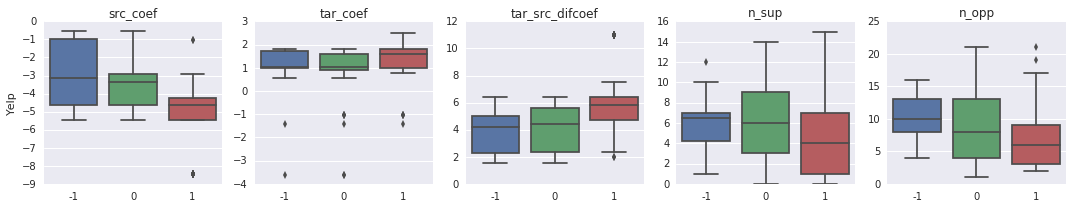

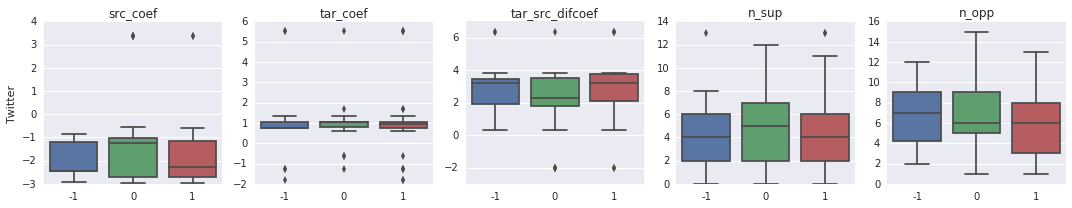

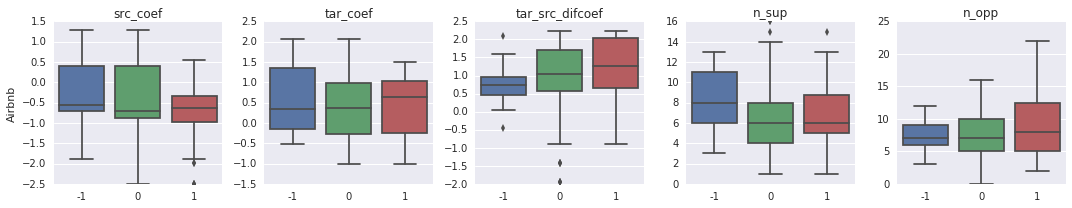

In [17]:
coef_list = ['src_coef','tar_coef','tar_src_difcoef','n_sup','n_opp']
coef_amt_relation(coef_list,plot_type='box')

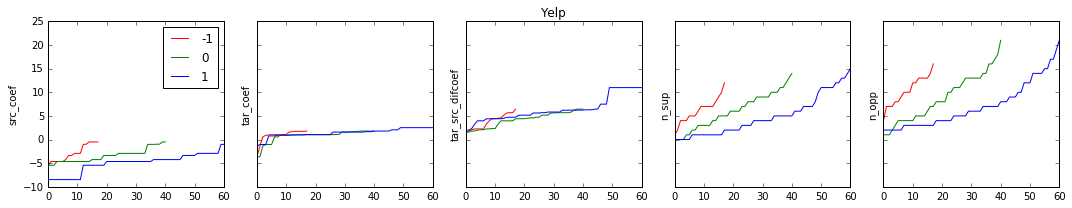

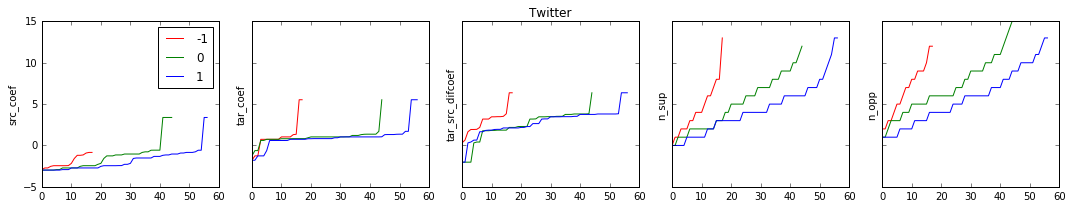

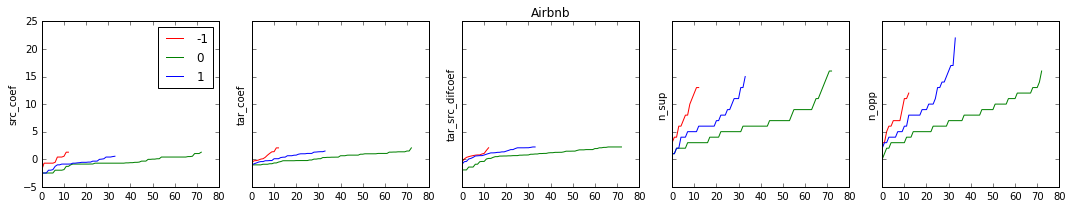

In [200]:
coef_list = ['src_coef','tar_coef','tar_src_difcoef','n_sup','n_opp']
coef_amt_relation(coef_list)

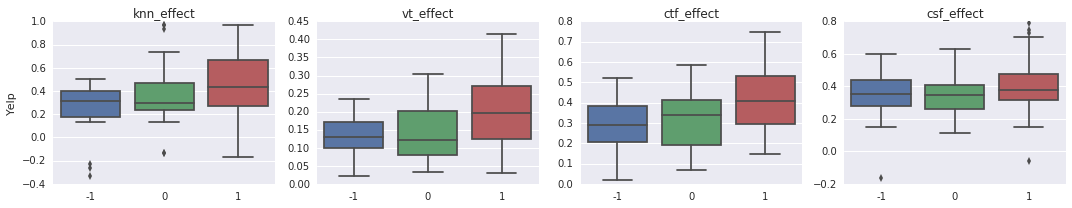

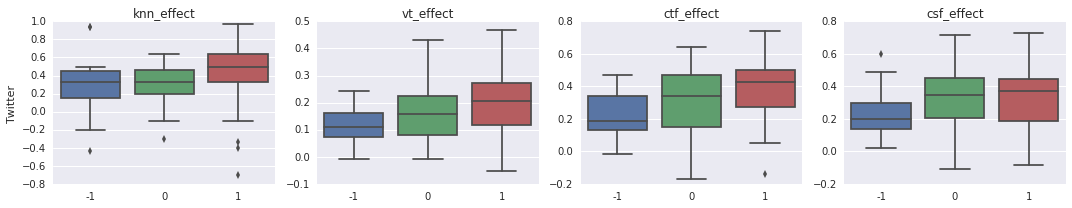

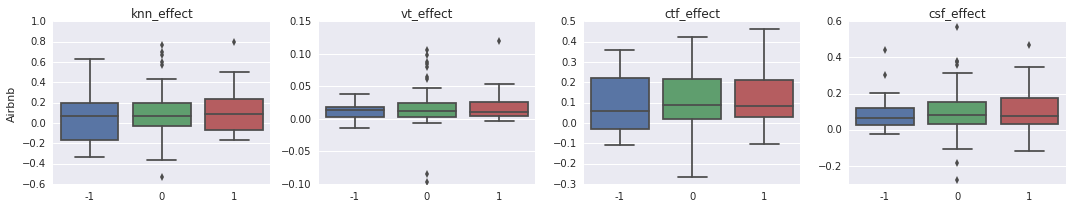

In [18]:
effect_list = ['knn_effect','vt_effect','ctf_effect','csf_effect']
coef_amt_relation(effect_list,plot_type='box')

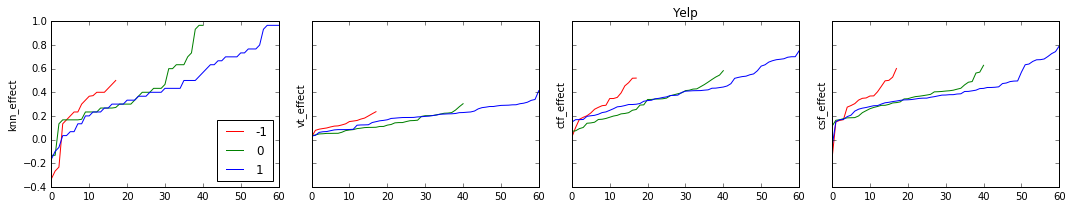

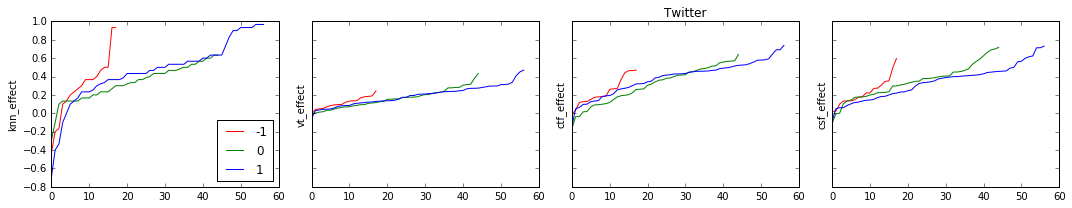

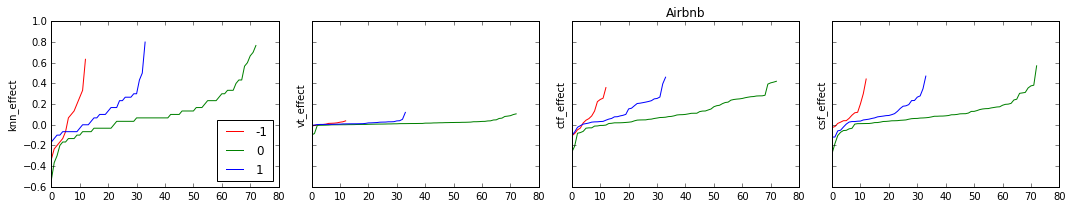

In [201]:
effect_list = ['knn_effect','vt_effect','ctf_effect','csf_effect']
coef_amt_relation(effect_list)